In [35]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
import pdb

In [53]:
##################################
######  Helper Functions    ######
##################################

exon_count= 194165

def Conf_matrix(new_df):
    data = {'chr':[0]*exon_count,
        'start':[0]*exon_count,
        'end':[0]*exon_count,
        'DEL_TP': [0]*exon_count,
        'DEL_FP': [0]*exon_count,
        'DEL_TN': [0]*exon_count,
        'DEL_FN': [0]*exon_count,

        'DUP_TP': [0]*exon_count,
        'DUP_FP': [0]*exon_count,
        'DUP_TN': [0]*exon_count,
        'DUP_FN': [0]*exon_count
        }

    confusion_matrix = pd.DataFrame(data)

    ind = (new_df[:,3]=='<DEL>') *  (new_df[:,4]=='<DEL>')
    confusion_matrix.loc[ind,"DEL_TP"] += 1
    confusion_matrix.loc[ind,"DUP_TN"] += 1

    ind = (new_df[:,3]=='<DEL>') *  (new_df[:,4]=='<DUP>')
    confusion_matrix.loc[ind,"DEL_FN"] += 1
    confusion_matrix.loc[ind,"DUP_FP"] += 1

    ind = (new_df[:,3]=='<DEL>') *  (new_df[:,4]=='<NO-CALL>')
    confusion_matrix.loc[ind,"DEL_FN"] += 1
    confusion_matrix.loc[ind,"DUP_TN"] += 1

    ind = (new_df[:,3]=='<DUP>') *  (new_df[:,4]=='<DEL>')
    confusion_matrix.loc[ind,"DEL_FP"] += 1
    confusion_matrix.loc[ind,"DUP_FN"] += 1

    ind = (new_df[:,3]=='<DUP>') *  (new_df[:,4]=='<NO-CALL>')
    confusion_matrix.loc[ind,"DUP_FN"] += 1
    confusion_matrix.loc[ind,"DEL_TN"] += 1

    ind = (new_df[:,3]=='<DUP>') *  (new_df[:,4]=='<DUP>')
    confusion_matrix.loc[ind,"DUP_TP"] += 1
    confusion_matrix.loc[ind,"DEL_TN"] += 1

    ind = (new_df[:,3]=='<NO-CALL>') *  (new_df[:,4]=='<DEL>')
    confusion_matrix.loc[ind,"DEL_FP"] += 1
    confusion_matrix.loc[ind,"DUP_TN"] += 1

    ind = (new_df[:,3]=='<NO-CALL>') *  (new_df[:,4]=='<DUP>')
    confusion_matrix.loc[ind,"DUP_FP"] += 1
    confusion_matrix.loc[ind,"DEL_TN"] += 1

    ind = (new_df[:,3]=='<NO-CALL>') *  (new_df[:,4]=='<NO-CALL>')
    confusion_matrix.loc[ind,"DUP_TN"] += 1
    confusion_matrix.loc[ind,"DEL_TN"] += 1

    confusion_matrix["chr"] = new_df[:,0]
    confusion_matrix["start"] = new_df[:,1]
    confusion_matrix["end"] = new_df[:,2]
    confusion_matrix = confusion_matrix.drop_duplicates(subset=['chr','start','end'])
    confusion_matrix=confusion_matrix.reset_index()
    return confusion_matrix

def GC_content_graph(confusion_matrix,intervals,title):
    results = {}
    for gc_content in intervals:
        if(gc_content[0]=='<'):
            lower_limit = int(gc_content.split('<')[1].split('%')[0])
            filtered_conf_matrix = confusion_matrix[confusion_matrix["GC content"] <= lower_limit]
        elif(gc_content[0]=='>'):
            upper_limit = int(gc_content.split('>')[1].split('%')[0] ) 
            filtered_conf_matrix = confusion_matrix[confusion_matrix["GC content"] >= upper_limit]
        else:
            lower = int(gc_content.split("%")[0].split("-")[0]) 
            upper = int(gc_content.split("%")[0].split("-")[1])
            filtered_conf_matrix = confusion_matrix[(confusion_matrix["GC content"] >= lower) & (confusion_matrix["GC content"] <= upper) ]

        del_tp = sum(filtered_conf_matrix["DEL_TP"])
        del_fp = sum(filtered_conf_matrix["DEL_FP"])
        del_fn = sum(filtered_conf_matrix["DEL_FN"])

        dup_tp = sum(filtered_conf_matrix["DUP_TP"])
        dup_fp = sum(filtered_conf_matrix["DUP_FP"])
        dup_fn = sum(filtered_conf_matrix["DUP_FN"])

        del_prec = del_tp / (del_tp+del_fp+0.000000000000001)
        del_recall = del_tp / (del_tp+del_fn+0.000000000000001)

        dup_prec = dup_tp / (dup_tp+dup_fp+0.000000000000001)
        dup_recall = dup_tp / (dup_tp+dup_fn+0.000000000000001)    

        results[gc_content] = {"DEL_PREC":del_prec, "DEL_RECALL":del_recall, "DUP_PREC": dup_prec, "DUP_RECALL":dup_recall }
        
    del_recall_list = []
    del_prec_list = []
    dup_recall_list = []
    dup_prec_list = []

    for i in results.keys():
        del_prec_list.append(results[i]["DEL_PREC"])
        del_recall_list.append(results[i]["DEL_RECALL"])
        dup_prec_list.append(results[i]["DUP_PREC"])
        dup_recall_list.append(results[i]["DUP_RECALL"])  

    f1_del = 2 * (np.array(del_prec_list) * np.array(del_recall_list)) / (np.array(del_prec_list) + np.array(del_recall_list)+0.000000000000001)
    plt.plot(intervals,f1_del,label="DEL-F1")
    plt.plot(intervals,del_recall_list, linestyle = 'dotted',label="DEL-Recall")
    plt.plot(intervals,del_prec_list, linestyle = 'dotted',label="DEL-Precision")
    #plt.xticks(rotation=90)
    #plt.yticks(bin_ticks)
    plt.xlabel("GC Percantage of Exons")
    #plt.ylabel("Performance")
    #plt.title("DEL performance")
    plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.tight_layout()
    plt.legend()
    plt.title(title)
    plt.savefig(title+"_GC_Content_DEL_recall_precision.png")
    plt.show()

    f1_dup = 2 * (np.array(dup_prec_list) * np.array(dup_recall_list)) / (np.array(dup_prec_list) + np.array(dup_recall_list)++0.000000000000001)
    plt.plot(intervals,f1_dup,label="DUP-F1")
    plt.plot(intervals,dup_recall_list, linestyle = 'dotted',label="DUP-Recall")
    plt.plot(intervals,dup_prec_list, linestyle = 'dotted',label="DUP-Precision")
    #plt.xticks(rotation=90)
    #plt.yticks(bin_ticks)
    plt.xlabel("GC Percantage of Exons")
    #plt.ylabel("Performance")
    #plt.title("dup performance")
    plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.tight_layout()
    plt.legend()
    plt.title(title)
    plt.savefig(title+"_GC_Content_DUP_recall_precision.png")
    plt.show()

def ProbeCount_plot(confusion_matrix,ProbeCounts,title):
    results = {}
    for ProbeCount in ProbeCounts:
        if(ProbeCount[-1]=='+'):
            probe_count = int(ProbeCount.split("+")[0])
            filtered_conf_matrix = confusion_matrix[confusion_matrix["Probe Count"] >= probe_count]
        else:
            probe_count = int(ProbeCount)
            filtered_conf_matrix = confusion_matrix[confusion_matrix["Probe Count"] == probe_count]
        del_tp = sum(filtered_conf_matrix["DEL_TP"])
        del_fp = sum(filtered_conf_matrix["DEL_FP"])
        del_fn = sum(filtered_conf_matrix["DEL_FN"])

        dup_tp = sum(filtered_conf_matrix["DUP_TP"])
        dup_fp = sum(filtered_conf_matrix["DUP_FP"])
        dup_fn = sum(filtered_conf_matrix["DUP_FN"])

        del_prec = del_tp / (del_tp+del_fp+0.000000000000001)
        del_recall = del_tp / (del_tp+del_fn+0.000000000000001)

        dup_prec = dup_tp / (dup_tp+dup_fp+0.000000000000001)
        dup_recall = dup_tp / (dup_tp+dup_fn+0.000000000000001)    

        results[ProbeCount] = {"DEL_PREC":del_prec, "DEL_RECALL":del_recall, "DUP_PREC": dup_prec, "DUP_RECALL":dup_recall }

    bin_ticks = ProbeCounts

    del_recall_list = []
    del_prec_list = []
    dup_recall_list = []
    dup_prec_list = []

    for i in results.keys():
        del_prec_list.append(results[i]["DEL_PREC"])
        del_recall_list.append(results[i]["DEL_RECALL"])
        dup_prec_list.append(results[i]["DUP_PREC"])
        dup_recall_list.append(results[i]["DUP_RECALL"])   

    f1_del = 2 * (np.array(del_prec_list) * np.array(del_recall_list)) / (np.array(del_prec_list) + np.array(del_recall_list)+0.000000000000001)
    plt.plot(bin_ticks,f1_del,label="DEL-F1")
    plt.plot(bin_ticks,del_recall_list, linestyle = 'dotted',label="DEL-Recall")
    plt.plot(bin_ticks,del_prec_list, linestyle = 'dotted',label="DEL-Precision")
    #plt.xticks(rotation=90)
    #plt.yticks(bin_ticks)
    plt.xlabel("Number Of Probes")
    #plt.ylabel("Performance")
    #plt.title("DEL performance")
    plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.tight_layout()
    plt.legend()
    plt.title(title)
    plt.savefig(title+"_ProbeCount_DEL_recall_precision.png")
    plt.show()

    f1_dup = 2 * (np.array(dup_prec_list) * np.array(dup_recall_list)) / (np.array(dup_prec_list) + np.array(dup_recall_list)+0.000000000000001)
    plt.plot(bin_ticks,f1_dup,label="DUP-F1")
    plt.plot(bin_ticks,dup_recall_list, linestyle = 'dotted',label="DUP-Recall")
    plt.plot(bin_ticks,dup_prec_list, linestyle = 'dotted',label="DUP-Precision")
    #plt.xticks(rotation=90)
    #plt.yticks(bin_ticks)
    plt.xlabel("Number Of Probes")
    #plt.ylabel("Performance")
    #plt.title("dup performance")
    plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.tight_layout()
    plt.legend()
    plt.title(title)
    #plt.show()
    plt.savefig(title+"_ProbeCount_DUP_recall_precision.png")



 ## NimbleGen SeqCap v3 (NA12891)

In [50]:
preds_ = np.array([])
wgs_preds_ = np.array([])

ecole_calls_data = pd.read_csv("NA12878_HISEQ4000.csv" , sep=",",header=None)
wgs_calls_data = pd.read_csv("Groundtruth_NA12878.csv", sep=",",header=None)

new_df = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = [0,1,2]).values

wgs_preds_n = np.array(new_df[:,3]) 

preds_n= np.array(new_df[:,4]) 

new_df[preds_n == 2,4] = "<DEL>"
new_df[preds_n == 1,4] = "<DUP>"
new_df[preds_n == 0,4] = "<NO-CALL>"
confusion_matrix = Conf_matrix(new_df)

gc_content = pd.read_csv("exon_region_gc_v2.txt", sep="\t",header=0)
confusion_matrix = pd.merge(confusion_matrix, gc_content,  how='left', left_on=["chr","start","end"], right_on = ["chr","start","end"])

probe_counts = pd.read_csv("NimbleGen_v3_Exome_regions_probeCount.txt", sep="\t",header=0)
confusion_matrix = pd.merge(confusion_matrix, probe_counts,  how='left', left_on=["chr","start","end"], right_on = ["chr","start","end"])

confusion_matrix = confusion_matrix.drop_duplicates(subset=['chr','start','end'])
confusion_matrix=confusion_matrix.reset_index()
confusion_matrix = confusion_matrix.drop(columns=["level_0","index"])

#confusion_matrix.to_excel("exon_loc_confusion_matrix.xlsx",sheet_name='Sheet_name_1')
#np.save("confusion_matrix.npy", confusion_matrix)
confusion_matrix

,chr,start,end,DEL_TP,DEL_FP,DEL_TN,DEL_FN,DUP_TP,DUP_FP,DUP_TN,DUP_FN,GC content,Probe Count
0,chr1,14642,14882,0,0,1,0,0,1,0,0,65.000000,1
1,chr1,14943,15063,0,0,1,0,0,1,0,0,62.500000,1
2,chr1,15751,15990,0,0,1,0,0,1,0,0,52.301255,1
3,chr1,16599,16719,0,0,1,0,1,0,0,0,65.833333,1
4,chr1,16834,17074,0,0,1,0,1,0,0,0,59.166667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192799,chrY,57191778,57192018,1,0,0,0,0,0,1,0,59.583333,1
192800,chrY,57192595,57192715,1,0,0,0,0,0,1,0,61.666667,1
192801,chrY,57194024,57194144,1,0,0,0,0,0,1,0,55.000000,1
192802,chrY,57196309,57196644,1,0,0,0,0,0,1,0,65.970149,1


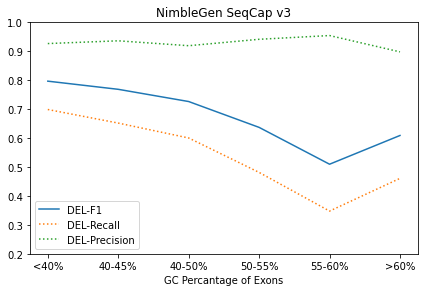

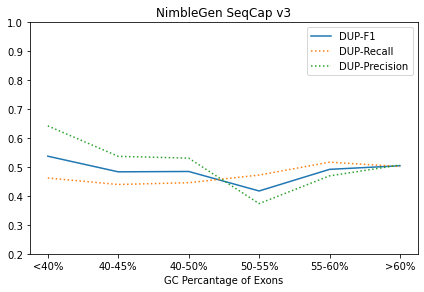

In [51]:
GC_contents = ["<40%","40-45%","40-50%","50-55%","55-60%",">60%"]
GC_content_graph(confusion_matrix,GC_contents, "NimbleGen SeqCap v3")

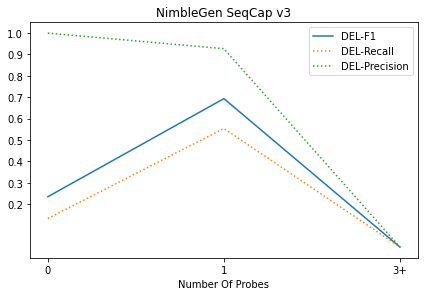

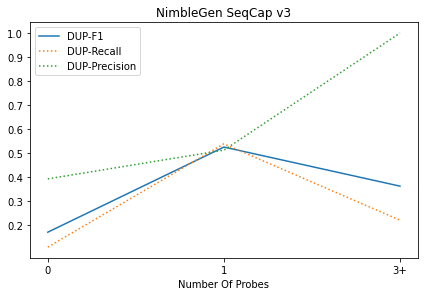

In [55]:
probeCounts = ["0","1","2","3+"]
ProbeCount_plot(confusion_matrix,probeCounts,title="NimbleGen SeqCap v3")

In [47]:
confusion_matrix[confusion_matrix["Probe Count"]==3]

,chr,start,end,DEL_TP,DEL_FP,DEL_TN,DEL_FN,DUP_TP,DUP_FP,DUP_TN,DUP_FN,GC content,Probe Count
10677,chr1,143956374,143956494,0,0,1,0,0,0,1,0,36.666667,3
10897,chr1,146132151,146132271,0,0,1,0,0,0,1,0,38.333333,3
48876,chr4,74450335,74450575,0,0,1,0,0,0,1,0,36.250000,3
86981,chr8,144238986,144239106,0,0,1,0,0,0,1,0,67.500000,3
89108,chr9,41908548,41908788,0,0,1,0,0,0,0,1,40.416667,3
89109,chr9,41906822,41907040,0,0,1,0,0,0,0,1,33.944954,3
96140,chr10,17775979,17776219,0,0,1,0,0,0,1,0,33.333333,3
97277,chr10,45888118,45888358,0,0,1,0,0,0,1,0,40.833333,3
97278,chr10,45892409,45892529,0,0,1,0,0,0,1,0,40.833333,3
97279,chr10,45896154,45896274,0,0,1,0,0,0,1,0,34.166667,3


## SeqCap EZ Human Exome Library v3.0 (NA12891) SRR1611182

In [40]:
preds_ = np.array([])
wgs_preds_ = np.array([])

ecole_calls_data = pd.read_csv("SRR1611182_ecole_exonlevel.csv" , sep="\t",header=0)
wgs_calls_data = pd.read_csv("Groundtruth_NA12878.csv", sep=",",header=None)

new_df_ = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = ["Chromosome","CNV Start Index","CNV End Index"])
new_df_ = new_df_.drop(columns=['Sample Name', 'Chromosome',"CNV Start Index","CNV End Index"])
new_df_.rename(columns = {'ECOLÉ Prediction':4}, inplace = True)
new_df = new_df_.values

wgs_preds_n = np.array(new_df[:,3]) 

preds_n= np.array(new_df[:,4]) 

new_df[preds_n == "DEL",4] = "<DEL>"
new_df[preds_n == "DUP",4] = "<DUP>"
new_df[preds_n == "NO-CALL",4] = "<NO-CALL>"

confusion_matrix_2 = Conf_matrix(new_df)

gc_content = pd.read_csv("exon_region_gc_v2.txt", sep="\t",header=0)
confusion_matrix_2 = pd.merge(confusion_matrix_2, gc_content,  how='left', left_on=["chr","start","end"], right_on = ["chr","start","end"])

probe_counts = pd.read_csv("seqCap_EZ_Exome_v3_probeCount.txt", sep="\t",header=0)
confusion_matrix_2 = pd.merge(confusion_matrix_2, probe_counts,  how='left', left_on=["chr","start","end"], right_on = ["chr","start","end"])

confusion_matrix_2 = confusion_matrix_2.drop_duplicates(subset=['chr','start','end'])
confusion_matrix_2 = confusion_matrix_2.reset_index()
confusion_matrix_2 = confusion_matrix_2.drop(columns=["level_0","index"])


#confusion_matrix_2.to_excel("SRR1611182_exon_loc_confusion_matrix.xlsx",sheet_name='SRR1611182')
#np.save("confusion_matrix.npy", confusion_matrix)
confusion_matrix_2

,chr,start,end,DEL_TP,DEL_FP,DEL_TN,DEL_FN,DUP_TP,DUP_FP,DUP_TN,DUP_FN,GC content,Probe Count
0,chr1,14642,14882,0,0,1,0,0,1,0,0,65.000000,2
1,chr1,14943,15063,0,0,1,0,0,1,0,0,62.500000,2
2,chr1,15751,15990,0,0,1,0,0,1,0,0,52.301255,2
3,chr1,16599,16719,0,0,1,0,1,0,0,0,65.833333,1
4,chr1,16834,17074,0,0,1,0,1,0,0,0,59.166667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192799,chrY,57191778,57192018,1,0,0,0,0,0,1,0,59.583333,1
192800,chrY,57192595,57192715,1,0,0,0,0,0,1,0,61.666667,1
192801,chrY,57194024,57194144,1,0,0,0,0,0,1,0,55.000000,1
192802,chrY,57196309,57196644,1,0,0,0,0,0,1,0,65.970149,2


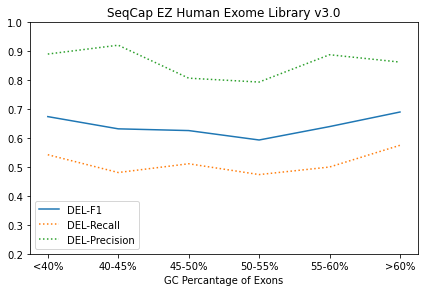

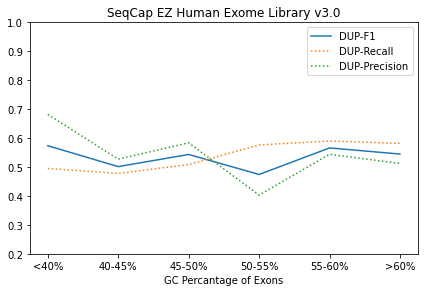

In [41]:
GC_contents = ["<40%","40-45%","45-50%","50-55%","55-60%",">60%"]
GC_content_graph(confusion_matrix_2,GC_contents,title="SeqCap EZ Human Exome Library v3.0")

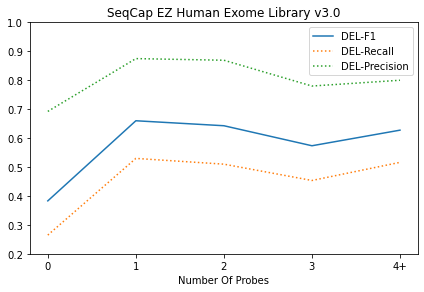

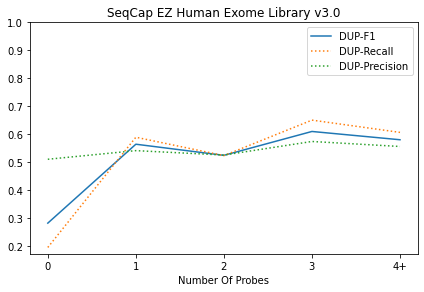

In [42]:
probeCounts = ["0","1","2","3","4+"]
ProbeCount_plot(confusion_matrix_2,probeCounts,title="SeqCap EZ Human Exome Library v3.0")